In [1]:
import numpy as np
import pandas as pd
from scipy import stats, special
import matplotlib.pyplot as plt
import seaborn as sns
import importlib.util,os,time
from matplotlib.lines import Line2D
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

In [2]:
# functions
def boxtpm(x, lmbda):
    return special.inv_boxcox(x, lmbda)

#https://stackoverflow.com/questions/30657453/fitting-a-straight-line-to-a-log-log-curve-in-matplotlib
def powerfit(x, y, xnew):
    """line fitting on log-log scale"""
    k, m = np.polyfit(np.log(x), np.log(y), 1)
    return np.exp(m) * xnew**(k)

def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

def is_odd(num):
    return num & 0x1

def get_dist_inner_loop(x):
    '''for distances'''
    s,x2,f_dist,k = x
    tmp = []
    for t in x2:
        if s=='' or t=='':
            tmp.append(np.nan)
        else:
            tmp.append(f_dist(s,t,k))
    return tmp #np.argmax(tmp) ## return distance or closest train idx

def get_dist_k_parallel(x1,x2,f_dist,k,output='argman'):
    # parallelized version
    ncores = mp.cpu_count()
    dist = []
    with mp.Pool(processes=ncores) as p:
        args = [(s,x2,f_dist,k) for s in x1]
        dist.append(p.map(get_dist_inner_loop,args))
    return dist

def makeNucSeq(input):
    # input is whole Xhot array
    bases = np.array(['N','A','C','G','T'])
    output = []
    for i in input:
        tmp = np.concatenate([np.zeros((i.shape[0],1)),i],axis=1).astype('bool')
        output.append(''.join(bases[np.argmax(tmp,axis = 1)]))
    return output

def seq_ratio(s1,s2,k):
    return lv.ratio(s1,s2)

complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A'} 

def reverse_complement(seq):    
    bases = list(seq) 
    bases = reversed([complement.get(base,base) for base in bases])
    bases = ''.join(bases)
    return bases

reverse_complement('ATGC')

def fix_pvals(x):
    if x < 1e-16:
        x=1e-16
    return x

def coeff_determination(y_true, y_pred):
    SS_res =  np.sum(np.square(y_true-y_pred))
    SS_tot = np.sum(np.square(y_true-np.mean(y_true)))
    return (1-SS_res/(SS_tot+1e-8))

def zscore(x):
    x = np.transpose(x)
    #z = stats.zscores(x)
    z = (x-np.mean(x,axis=0))/np.std(x,axis=0)
    return np.transpose(z)

def dframe_stack_list(ins,col,typ='float32'):
    df = ins.copy(deep=True)
    s = df[col].apply(lambda x: pd.Series(list(x)),1).stack() #.astype(typ)
    s.index = s.index.droplevel(-1)
    s.name = col
    del df[col]
    df = df.join(s)
    return df

def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    #title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, **kws)
    
def merge_data(df_sel,df_rules,df_motifs):

    # rather merge all data
    df_sel6 = (dframe_stack_list(df_sel[df_sel
                                           .list_rules
                                           .apply(len)>0],'list_rules')
              )
    print(df_sel6.shape)

    # convert all to frozenset
    df_sel6['ruleset'] = df_sel6.list_rules.apply(frozenset)
    df_rules['ruleset'] = df_rules.items_cluster.apply(frozenset)

    df_sel6 = df_sel6.merge(df_rules,on='ruleset',how='left')
    print(df_sel6.shape)
    df_sel6.columns

    # motifs
    df_sel6m = (dframe_stack_list(df_sel[df_sel
                                           .list_motifs
                                            .apply(len)>0],'clusterset')
              )
    print(df_sel6m.shape)
    df_sel6m = df_sel6m.merge(df_motifs,
                            left_on='clusterset',
                            right_on='cluster',
                            how='left')
    print(df_sel6m.shape)
    df_sel6m.columns

    # tfbs
    df_sel6t = df_sel6m.dropna(subset=['combined_id'])
    print(df_sel6t.shape)
    df_sel6t.columns
    
    return df_sel6, df_sel6m, df_sel6t
    
def fix_strings_list_space_int(x):
    return [int(xxx) for xxx in [str(xx.replace("'","")
                                     .replace(')','')
                                     .replace('(','')
                                     .replace(' ','')
                                     .replace('[','')
                                     .replace(']','')
                                     .replace(',','')) for xx in list(x.split(' '))] if len(xxx)>0]

# fix load 
def fix_strings_list(x):
    return [xxx for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace(' ','')).replace('[','').replace(']','') for xx in list(x.split(','))] if len(xxx)>0]

def fix_strings_list_space(x):
    return [xxx for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace(' ','')).replace('[','').replace(']','') for xx in list(x.split(' '))] if len(xxx)>0]

def fix_float_list_comma(x):
    return [float(xxx) for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace('[','').replace(']','').replace(' ','')) for xx in list(x.split(','))] if len(xxx)>0]

def fix_float_list_space(x):
    return [float(xxx) for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace('[','').replace(']','')) for xx in list(x.split(' '))] if len(xxx)>0] #.replace(' ',''))

def fix_int_list(x):
    return [int(xxx) for xxx in [str(xx.replace("'","").replace('.','').replace(' ','')).replace('[','').replace(']','') for xx in list(x.split(' '))] if len(xxx)>0]

def fix_int_list_comma(x):
    return [int(xxx) for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace('[','').replace(']','').replace(' ','')) for xx in list(x.split(','))] if len(xxx)>0]

def fix_strings_tuple(x):
    return tuple([xxx for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace(' ','')) for xx in list(x.split(','))] if len(xxx)>0])

def fix_int_tuple(x):
    return tuple([int(xxx) for xxx in [str(xx.replace("'","").replace(')','').replace('(','').replace(' ','')) for xx in list(x.split(','))] if len(xxx)>0])

def fix_frame(rules2):
    rules2['itemset'] = rules2.itemset.apply(fix_int_tuple)
    rules2['items_cluster'] = rules2.items_cluster.apply(fix_strings_tuple)
    rules2['items_regions'] = rules2.items_regions.apply(fix_strings_tuple)
    rules2['items_genes'] = rules2.items_genes.apply(fix_strings_tuple)
    rules2['items_gene_id'] = rules2.items_gene_id.apply(fix_strings_list)
    rules2['items_ytest'] = rules2.items_ytest.apply(fix_float_list_comma)
    rules2['ytpm'] = rules2.ytpm.apply(fix_float_list_space)
    rules2['antecedent'] = rules2.antecedent.apply(fix_int_list_comma)
    rules2['consequent'] = rules2.consequent.apply(fix_int_list_comma)
    return rules2    

def filter_rules(rules):
    '''removes duplicate itemsets'''
    rules['frozenset'] = rules.itemset.apply(frozenset)
    return (rules.
            sort_values(by='chi_pval') # lowest p-value subsets
            .drop_duplicates(subset=['frozenset'])
           )

def combining_function(x):
    tmp = []
    tmp2 = x.isnull()
    k = 0
    if all(tmp2):
        tmp = np.nan
    else:
        for b in tmp2:
            if (not b):
                tmp.extend(list(x.iloc[k]))
            k+=1
        tmp = tuple(tmp)
    return tmp


In [3]:
# data params
folder = '../data/'
names_plot = ['Promoter','5UTR','3UTR','Terminator']
limits = np.array([[0,400],[400,500],[500,750],[750,1000]])
label_names =["0_none", "1_low", "2_medium", "3_high"]
lmbda = 0.22
corrf = stats.spearmanr


In [4]:
# load data

# load motifs
df_rules = pd.read_csv(folder+'rules_z2_08_k4_c6_s3_c001.csv')
df_rules = fix_frame(df_rules)
# drop precalculated values except y boxcox
df_rules.drop(columns=['y_mean','y_std','y_var','ytpm_mean','ytpm_std','ytpm_var','ytpm_median','ytpm'],
             inplace=True)
df_rules = filter_rules(df_rules)
print(df_rules.shape)

df_motifs = pd.read_csv(folder+'motifs_z2_08_k4_c6.csv')
df_motifs['genes'] = df_motifs.genes.apply(fix_int_list)
df_motifs['gene_ids'] = df_motifs.gene_ids.apply(fix_strings_list_space)
df_motifs['ytest'] = df_motifs.ytest.apply(fix_float_list_comma)

print(df_motifs.shape)

# add tfbs information
tomtom2 = pd.read_csv(folder+'tomtom_jaspar-fungi_08_trimmed.txt',sep='\t')
tomtom2.drop(index=tomtom2.index.values[-3:],inplace=True)#.drop(index=[10092,10093,10094])
df_dbs = tomtom2[(tomtom2['E-value']<0.05) & (tomtom2['q-value']<0.05)]
df_seqs_jaspar = (df_motifs
               .merge(df_dbs[['#Query ID','Target ID']],
                      left_on='cluster',right_on='#Query ID',
                      how='left')
              )
# actual unique annotated seqs
print(sum(df_seqs_jaspar['Target ID'].notnull())) 

tomtom2 = pd.read_csv(folder+'tomtom_yeastract_08_trimmed.txt',sep='\t')
tomtom2.drop(index=tomtom2.index.values[-3:],inplace=True)#.drop(index=[10092,10093,10094])
tomtom2.tail()
df_dbs = tomtom2[(tomtom2['E-value']<0.05) & (tomtom2['q-value']<0.05)]
df_seqs_yeastract = (df_motifs
               .merge(df_dbs[['#Query ID','Target ID']],
                      left_on='cluster',right_on='#Query ID',
                      how='left')
              )
# actual unique annotated seqs
print(sum(df_seqs_yeastract['Target ID'].notnull())) 

# groupby back to shape
df_motifs['jaspar_id'] = (df_seqs_jaspar
                            .groupby('cluster')['Target ID']
                            .apply(lambda x: tuple(x) if not any(x.isnull()) else np.nan)
                            .values
                           )
df_motifs['yeastract_id'] = (df_seqs_yeastract
                            .groupby('cluster')['Target ID']
                            .apply(lambda x: tuple(x) if not any(x.isnull()) else np.nan)
                            .values
                            )

df_motifs['combined_id'] = (df_motifs[['jaspar_id','yeastract_id']]
                            .apply(lambda x: combining_function(x), axis=1)
                             )

# sanity checks
print(df_motifs.combined_id.notnull().sum())
print(df_seqs_jaspar
    .groupby('cluster')['Target ID']
    .apply(lambda x: tuple(x) if not any(x.isnull()) else np.nan)
     .notnull().sum()
)

(116734, 18)
(2210, 19)
324
198
285
227


In [5]:
# load data
df_sel = pd.read_csv(folder+'motifs_metrics_generated_hl_1e2_10000.tsv',sep='\t')

# fix the data
df_sel[['list_motifs','list_tfbs','list_rules']]

df_sel['list_motifs'] = df_sel.list_motifs.apply(fix_strings_list_space_int)
df_sel.list_motifs.iloc[0]
df_sel['list_tfbs'] = df_sel.list_tfbs.apply(fix_strings_list_space)
df_sel.list_tfbs.iloc[0]
df_sel['list_rules'] = df_sel.list_rules.apply(lambda x: [tuple([str(xxx.replace("'","")
                                 .replace(')','')
                                 .replace('(','')
                                 .replace('[','')
                                 .replace(']','')
                                 .replace(',','')
                                 .replace(' ','')) for xxx in xx.split(' ') if len(xxx)>0]) for xx in x.split("),")])
df_sel.list_rules
df_sel['clusterset'] = (df_sel.clusterset
                        .apply(lambda x: x.replace('frozenset','').replace('{','').replace('}',''))
                        .apply(fix_strings_list_space)
                        .apply(lambda x: [xx.replace(',','') for xx in x])
                        .apply(frozenset)
                       )

df_sel_core = pd.read_csv(folder+'motifs_core_generated_hl_1e2_10000.tsv',sep='\t')
print(df_sel_core.shape)

# merge data
df_sel6, df_sel6m, df_sel6t = merge_data(df_sel,df_rules,df_motifs)


(20000, 31)
(317145, 42)
(317145, 61)
(728900, 42)
(728900, 64)
(194901, 64)


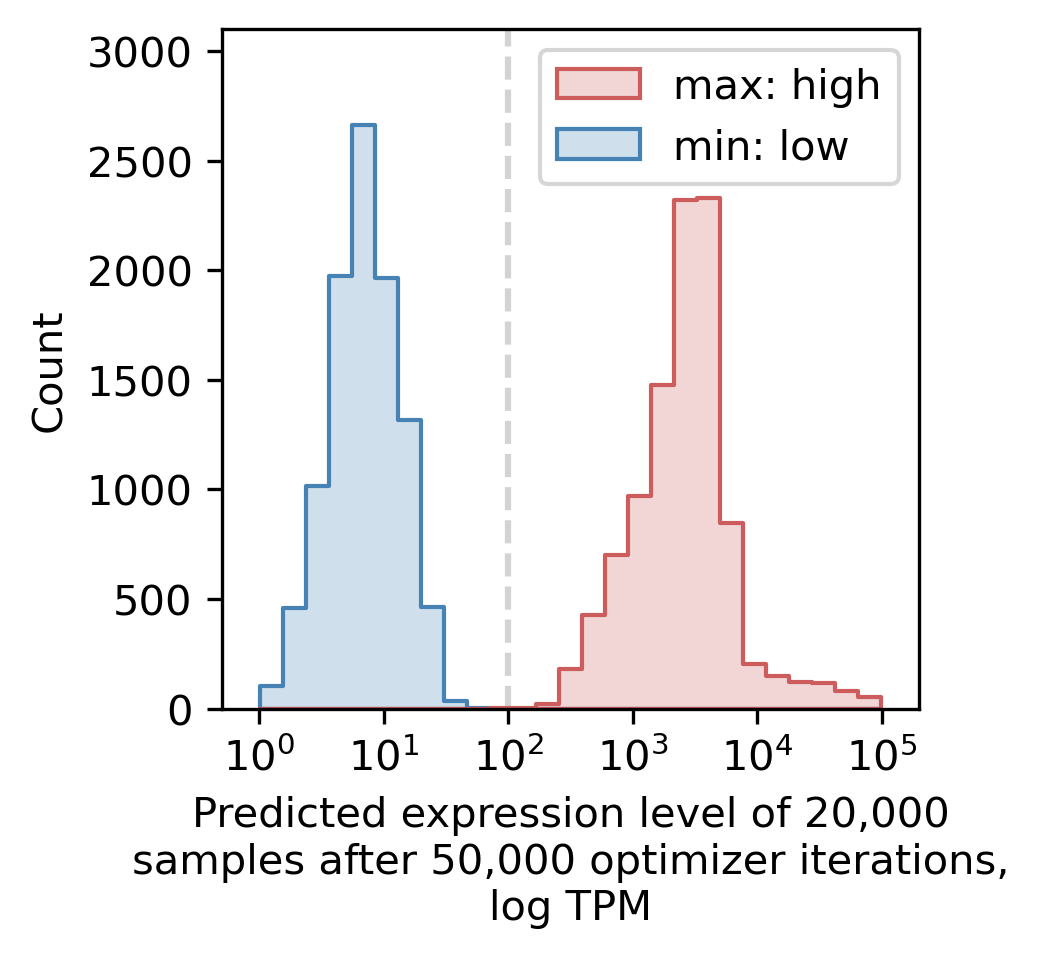

In [6]:
# Plot analysed data distribution
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
ax=sns.histplot(data=df_sel.replace({'optimization':{'max':'max: high', 'min': 'min: low'}}),
             x='y_tpm',log_scale=(True,False),
                hue='optimization',
             palette=['indianred','steelblue'],
             element="step",
                hue_order=['max: high', 'min: low']
            )
plt.plot([1e2,1e2],[0,100000],'--',c='lightgrey',zorder=-1)
plt.xticks([1e0,1e1,1e2,1e3,1e4,1e5])
plt.xlim(5e-1,2e5)
plt.ylim(0,3100)
plt.xlabel('Predicted expression level of 20,000\nsamples after 50,000 optimizer iterations,\nlog TPM')
move_legend(ax, "upper right",title='')
plt.show()


## Properties across whole constructs

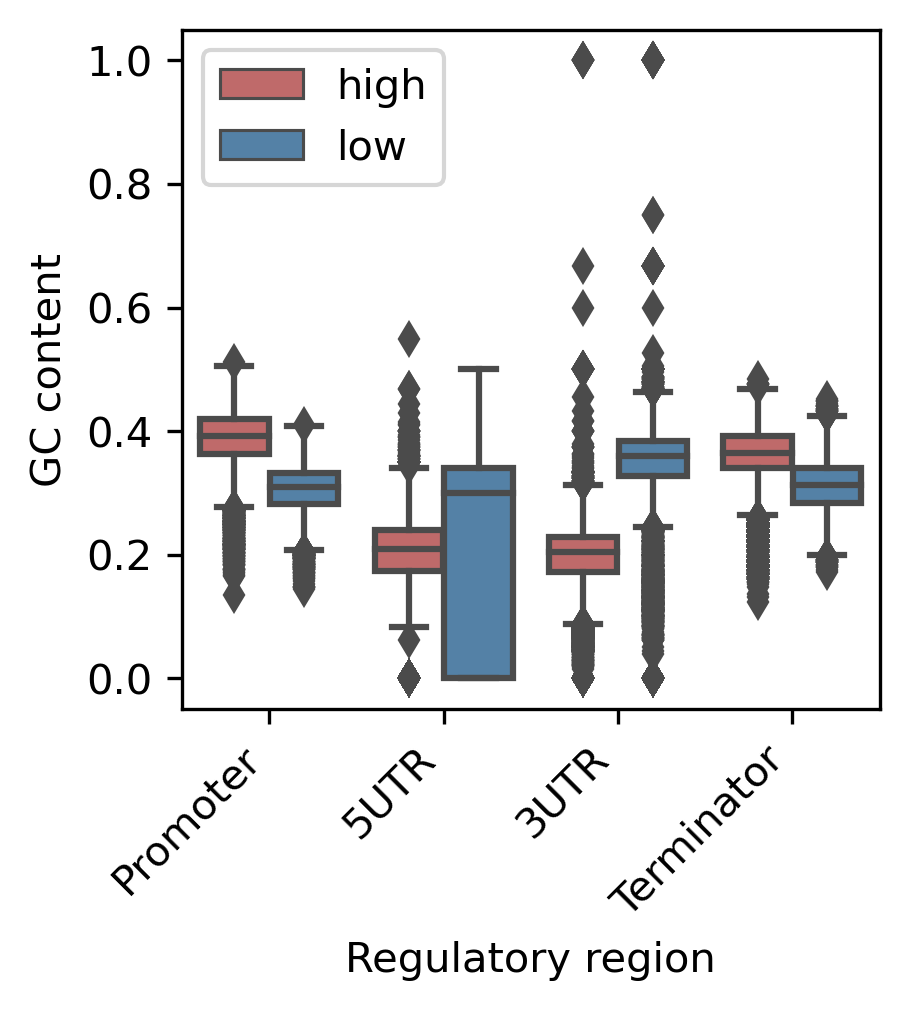

RanksumsResult(statistic=101.56793514663985, pvalue=0.0)
RanksumsResult(statistic=-47.96835868891945, pvalue=0.0)
RanksumsResult(statistic=-97.08021103186553, pvalue=0.0)
RanksumsResult(statistic=72.64670484778563, pvalue=0.0)
          gc_prom  gc_5utr  gc_3utr  gc_term
grouping                                    
high       0.3925     0.21    0.204    0.364
low        0.3100     0.30    0.360    0.312
grouping
high        NaN
low    -0.06725
dtype: float64
grouping
high      NaN
low     0.123
dtype: float64


In [7]:
# GC content
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
sns.boxplot(data=df_sel.melt(id_vars=['grouping'],value_vars=['gc_prom',
                                                           'gc_5utr',
                                                           'gc_3utr',
                                                           'gc_term',
                                                          ]),
           x='variable',y='value',hue='grouping',
           palette=['indianred','steelblue','lightgrey'])
plt.xticks(ticks=[0,1,2,3],
           labels=['Promoter','5UTR','3UTR','Terminator'],
           rotation=45,ha='right'
          )
plt.legend()
plt.xlabel('Regulatory region')
plt.ylabel('GC content')
plt.show()

# stats
for i in ['gc_prom','gc_5utr','gc_3utr','gc_term']:
    print(stats.ranksums(df_sel.query('grouping=="high"')[i].values, 
                   df_sel.query('grouping=="low"')[i].values)
         )
    
# fold changes
print(df_sel.groupby('grouping')['gc_prom','gc_5utr','gc_3utr','gc_term'].median())
print(df_sel.groupby('grouping')['gc_prom','gc_term'].median().diff().mean(axis=1))
print(df_sel.groupby('grouping')['gc_5utr','gc_3utr'].median().diff().mean(axis=1))


         len_5utr                                                       \
            count     mean        std  min    25%    50%    75%    max   
grouping                                                                 
high      10000.0  83.6584  35.577598  0.0  100.0  100.0  100.0  100.0   
low       10000.0  65.5172  46.030038  0.0    5.0  100.0  100.0  100.0   

         len_3utr                                                        
            count      mean        std  min    25%    50%    75%    max  
grouping                                                                 
high      10000.0  208.8386  80.654209  0.0  250.0  250.0  250.0  250.0  
low       10000.0  208.2437  86.533327  0.0  250.0  250.0  250.0  250.0  


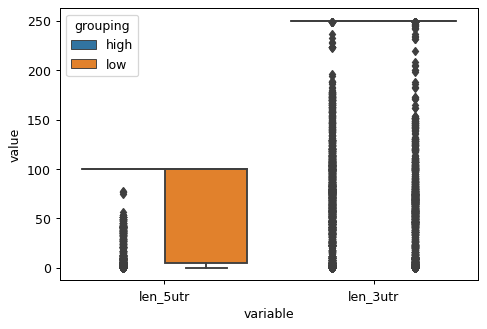

1.2768921748792683
RanksumsResult(statistic=22.210023984235068, pvalue=2.7479091780711682e-109)
RanksumsResult(statistic=-0.9555881954764999, pvalue=0.3392803277276992)


In [8]:
# UTR lengths

mpl.rcParams['figure.dpi'] = 90
print(df_sel.groupby('grouping')['len_5utr','len_3utr'].describe())
sns.boxplot(data=df_sel.melt(id_vars='grouping',value_vars=['len_5utr','len_3utr']),
           x='variable',hue='grouping',y='value'
           )
plt.show()

# value
print(df_sel.query('grouping=="high"')['len_5utr'].mean()/
               df_sel.query('grouping=="low"')['len_5utr'].mean()
     )

# ranksum
print(stats.ranksums(df_sel.query('grouping=="high"')['len_5utr'].values, 
               df_sel.query('grouping=="low"')['len_5utr'].values)
     )
print(stats.ranksums(df_sel.query('grouping=="high"')['len_3utr'].values, 
               df_sel.query('grouping=="low"')['len_3utr'].values)
     )


(742356, 13)


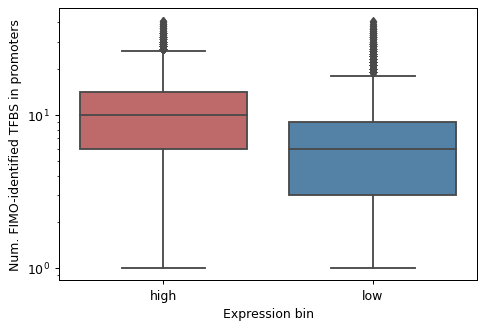

1.6666666666666667
RanksumsResult(statistic=-46.120159034927475, pvalue=0.0)


In [9]:
# load fimo
dfimo = (pd.read_csv(folder+'promoters_generated_hl_10000_1e2_fimo_out.tsv',sep='\t')
         .dropna(subset=['motif_alt_id'])
         .merge(df_sel[['idx','y_tpm','grouping']], # add in groupings
                    left_on='sequence_name',right_on='idx',
                    how='right'
                   )
        )
dfimo.columns = [i.replace('-', '_') for i in dfimo.columns]
dfimo['p_value'] = dfimo.p_value.astype(float)
dfimo['q_value'] = dfimo.q_value.astype(float)
print(dfimo.shape)
dfimo.head()

# reported values
data = (dfimo
           .query('q_value<0.05')
#            .merge(df_sel.grouping,right_index=True,
#                   left_on='sequence_name',how='left')
            .groupby(['grouping','sequence_name'])
            .motif_id
            .count()
            .rename('num_motifs')
            .reset_index()
            )

mpl.rcParams['figure.dpi'] = 90       
sns.boxplot(data=data,
            y='num_motifs', x='grouping',
            palette=['indianred','steelblue']
           )
plt.yscale('log')
plt.xlabel('Expression bin')
plt.ylabel('Num. FIMO-identified TFBS in promoters')
plt.show()

tmp = data.groupby('grouping').num_motifs.median()
print(tmp.loc['high']/tmp.loc['low'])

# test for diff of means
print(stats.ranksums(data.query('grouping=="low"').num_motifs.values, 
               data.query('grouping=="high"').num_motifs.values)
     )

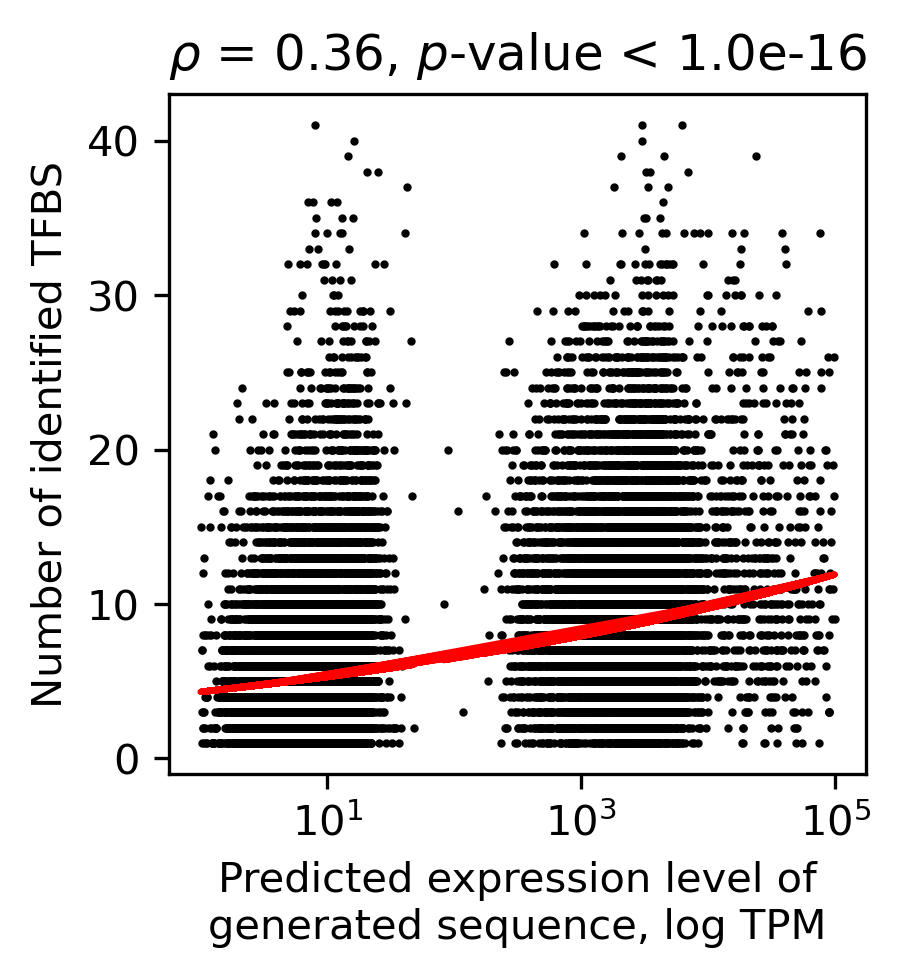

In [10]:
# Figure 5D
# is num tfbs or nunique tfbs correlated with typm?

tmp = (dfimo
.query('q_value<0.05')
 .groupby(['sequence_name'])
 .motif_id.count()
 .reset_index()
 .merge(dfimo[['sequence_name','y_tpm']].drop_duplicates(),
        on='sequence_name',how='left'
       )
)

mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
x = tmp.y_tpm.values
y = tmp.motif_id.values

slope1, intercept1, rvalue, pvalue, stderr = stats.linregress(np.log(x),np.log(y))
plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
k, m = np.polyfit(np.log(x), np.log(y), 1)
plt.plot(x, np.exp(m) * x**(k), 'r', label='fitted line')
plt.xscale('log')
#plt.yscale('log')
# plt.xlim(-0.001,0.08)
#plt.ylim(0.04,4)
plt.ylabel('Number of identified TFBS')
plt.xlabel('Predicted expression level of\ngenerated sequence, log TPM')
r,p = stats.spearmanr(x,y)
plt.title(r'$\rho$ = '+str("%.2f" % r)+ ', $p$-value < '+str("%.1e" % fix_pvals(p)))
plt.show()


RanksumsResult(statistic=30.482781388170004, pvalue=4.4076944166075704e-204)
RanksumsResult(statistic=45.01852785821797, pvalue=0.0)
RanksumsResult(statistic=49.31301108799899, pvalue=0.0)
2.25
1.2580645161290323
1.375


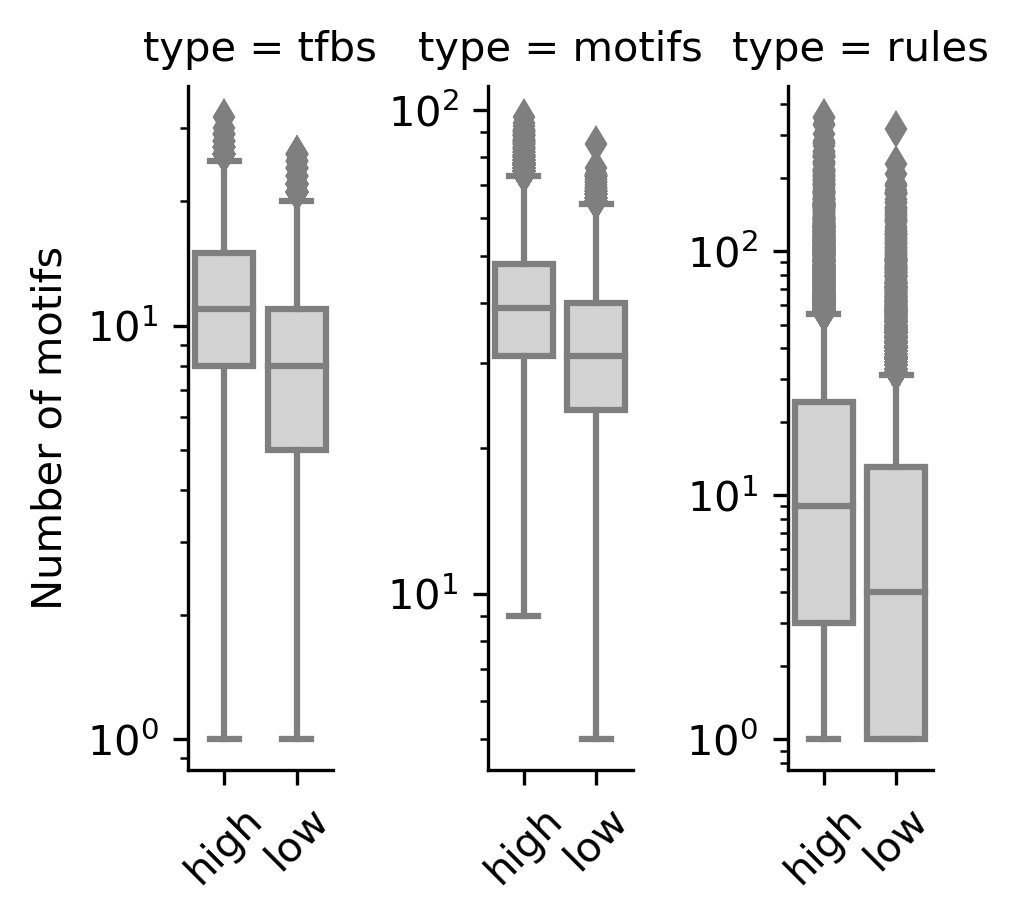

In [11]:
# Plot motifs and rules distributions

df_plot1 = ((df_sel6
       .groupby(['idx','grouping'])
       .ruleset
       .nunique()
       .rename('nunique')
        .reset_index()
        .assign(type='rules'))
.append(df_sel6m
       .groupby(['idx','grouping'])
       .clusterset
       .nunique()
       .rename('nunique')
        .reset_index()
        .assign(type='motifs')
    )
.append(df_sel6t
       .groupby(['idx','grouping'])
       .clusterset
       .nunique()
       .rename('nunique')
        .reset_index()
        .assign(type='tfbs')
       ))

df_plot1

mpl.rcParams['figure.dpi'] = 300
#plt.figure(figsize=(3,3))
g = sns.catplot(data=df_plot1,
           col='type',x='grouping',y='nunique',
            color='lightgrey',
            sharey=False,
            kind='box',
            col_order=['tfbs','motifs','rules'],
            height=3, aspect=0.34
           )
g.axes[0][0].set_yscale('log')
g.axes[0][1].set_yscale('log')
g.axes[0][2].set_yscale('log')
g.axes[0][0].set_ylabel('Number of motifs')
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
    axes.set_xlabel('')
#plt.tight_layout()

# stats - diff of means
print(stats.ranksums(df_plot1.query('type=="rules"').query('grouping=="high"')['nunique'].values, 
               df_plot1.query('type=="rules"').query('grouping=="low"')['nunique'].values)
     )
print(stats.ranksums(df_plot1.query('type=="motifs"').query('grouping=="high"')['nunique'].values, 
               df_plot1.query('type=="motifs"').query('grouping=="low"')['nunique'].values)
     )
print(stats.ranksums(df_plot1.query('type=="tfbs"').query('grouping=="high"')['nunique'].values, 
               df_plot1.query('type=="tfbs"').query('grouping=="low"')['nunique'].values)
     )

# percent higher
print(df_plot1.query('type=="rules"').query('grouping=="high"')['nunique'].median()/ 
    df_plot1.query('type=="rules"').query('grouping=="low"')['nunique'].median()
     )
print(df_plot1.query('type=="motifs"').query('grouping=="high"')['nunique'].median()/
    df_plot1.query('type=="motifs"').query('grouping=="low"')['nunique'].median()
     )
print(df_plot1.query('type=="tfbs"').query('grouping=="high"')['nunique'].median()/ 
    df_plot1.query('type=="tfbs"').query('grouping=="low"')['nunique'].median()
     )


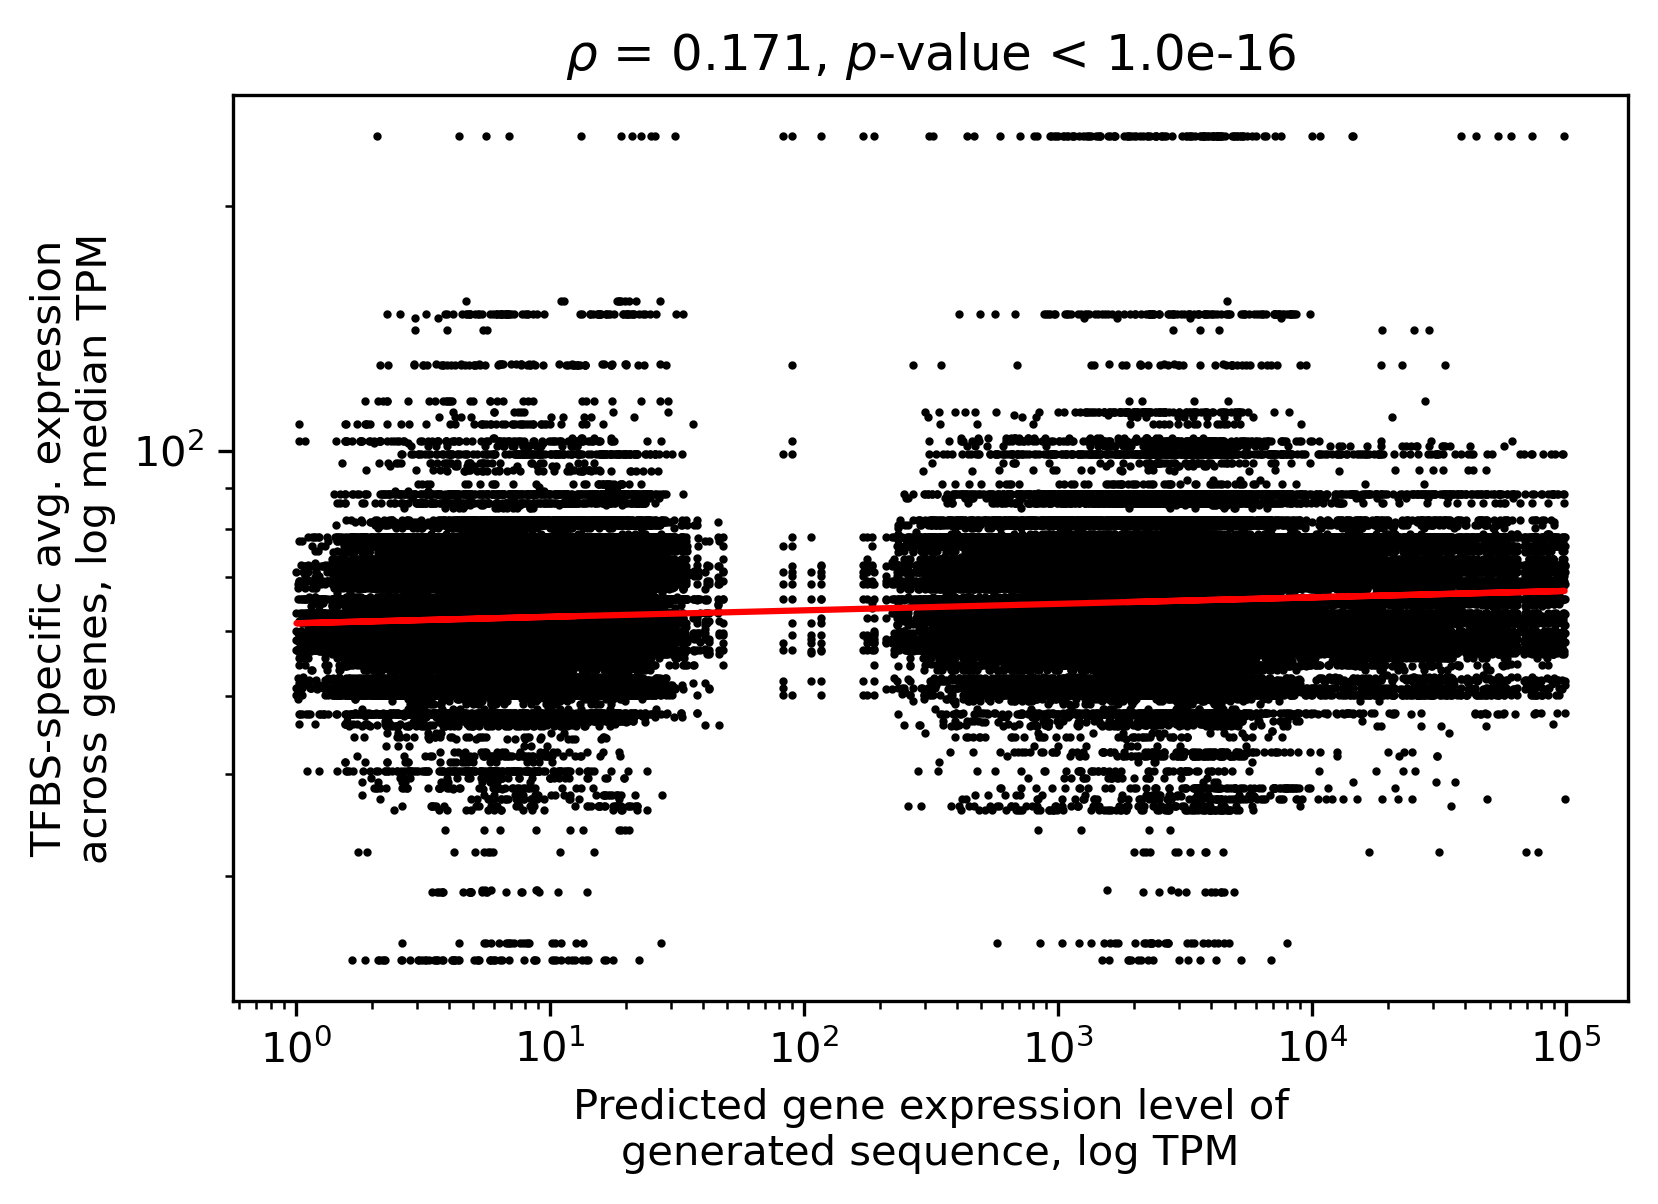

In [12]:
# Supplementary figure
# correlation predicted ytpms vs median ytpm across genes per tfbs/motifs/rules

#plt.figure(figsize=(4,3))
x = df_sel6t.y_tpm.values
y = df_sel6t.median_ytest.apply(boxtpm,lmbda=0.22).values

slope1, intercept1, rvalue, pvalue, stderr = stats.linregress(np.log(x),np.log(y))
plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
plt.plot(x, powerfit(x,y,x), 'r', label='fitted line')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('TFBS-specific avg. expression\nacross genes, log median TPM')
plt.xlabel('Predicted gene expression level of\ngenerated sequence, log TPM')
plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value < '+str("%.1e" % fix_pvals(pvalue)))
r,p = stats.spearmanr(x,y)
plt.title(r'$\rho$ = '+str("%.3f" % r)+ ', $p$-value < '+str("%.1e" % fix_pvals(p)))
plt.show()

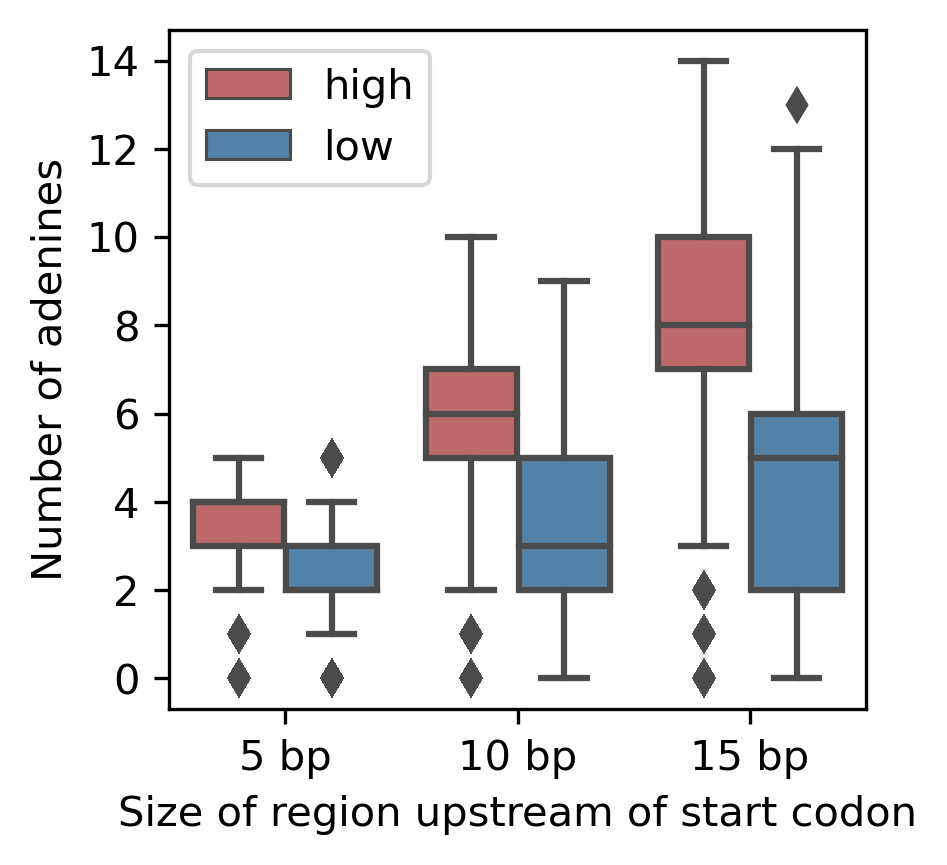

1.8666666666666665
RanksumsResult(statistic=67.31371724695623, pvalue=0.0)
RanksumsResult(statistic=74.4168015049728, pvalue=0.0)
RanksumsResult(statistic=75.28903442361339, pvalue=0.0)


In [13]:
# Kozak A enrichment
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
sns.boxplot(data= df_sel.melt(id_vars='grouping',
                              value_vars=['kozak_a5','kozak_a10','kozak_a15']),
            x='variable',y='value',hue='grouping',
           palette=['indianred','steelblue'])
plt.xticks(ticks=[0,1,2],
           labels=['5 bp','10 bp','15 bp'],
          )
plt.xlabel('Size of region upstream of start codon')
plt.ylabel('Number of adenines')
plt.legend()
plt.show()

# values for text
# average 50%
print((df_sel.groupby('grouping')['kozak_a5','kozak_a10','kozak_a15'].median().iloc[0]/
df_sel.groupby('grouping')['kozak_a5','kozak_a10','kozak_a15'].median().iloc[1]).mean())

# stats ranksum
for i in ['kozak_a5','kozak_a10','kozak_a15']:
    print(stats.ranksums(df_sel.query('grouping=="high"')[i].values, 
                   df_sel.query('grouping=="low"')[i].values)
         )


2.0572965155996556e-05 2.762510764875433


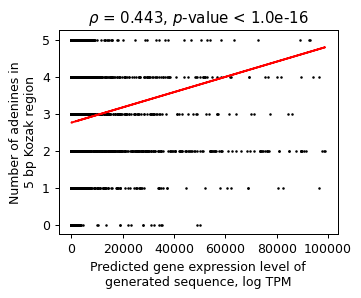

2.427206427682777e-05 4.419995662764522


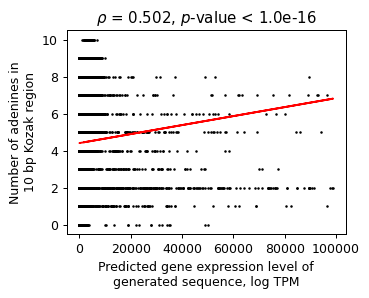

2.7796787078626463e-05 6.122767822313755


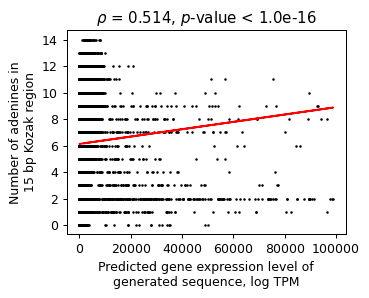

In [14]:
# Correlation analysis

for i in [5,10,15]:  
    mpl.rcParams['figure.dpi'] = 90
    plt.figure(figsize=(4,3))
    x = df_sel.y_tpm.values
    y = df_sel['kozak_a'+str(i)].values
    slope1, intercept1, rvalue, pvalue, stderr = stats.linregress(x,y)
    print(slope1, intercept1)
    plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
    plt.plot(x, intercept1+slope1*x, 'r', label='fitted line')
    plt.ylabel('Number of adenines in\n'+str(i)+' bp Kozak region')
    plt.xlabel('Predicted gene expression level of\ngenerated sequence, log TPM')
    plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value < '+str("%.1e" % fix_pvals(pvalue)))
    r,p = stats.spearmanr(x,y)
    plt.title(r'$\rho$ = '+str("%.3f" % r)+ ', $p$-value < '+str("%.1e" % fix_pvals(p)))
    plt.show()


polyat_3utr_pass    1.093148
posit_3utr_pass     1.059732
effic_3utr_pass     1.447172
dtype: float64


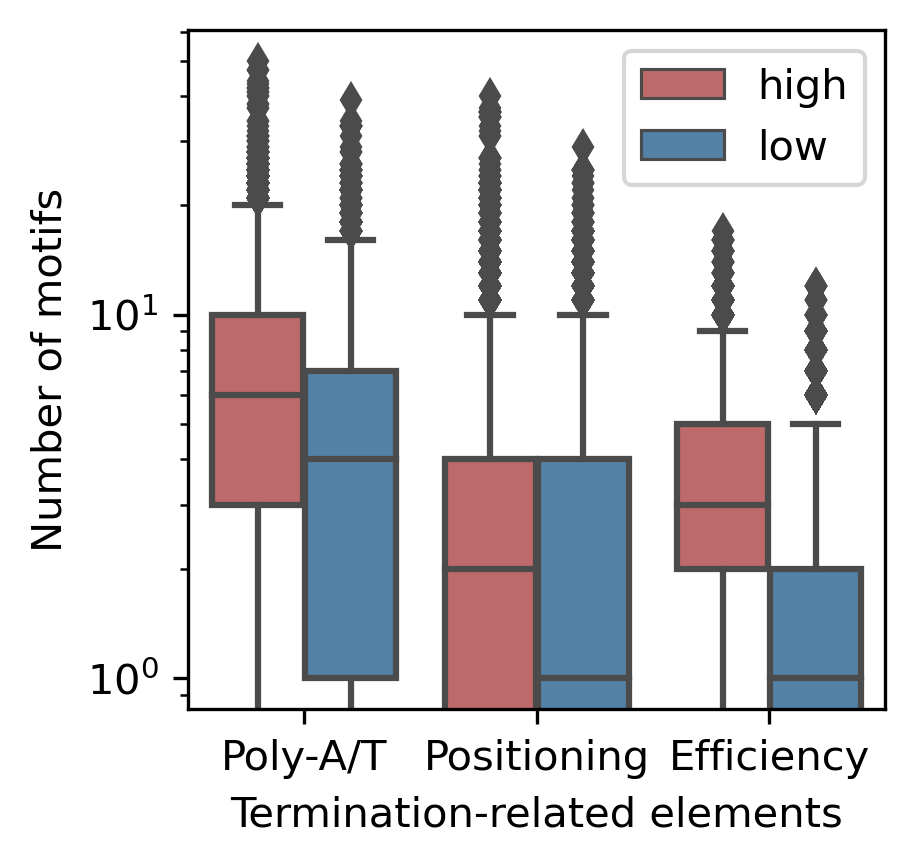

In [15]:
# Terminating motifs

print(df_sel.groupby('grouping')['polyat_3utr_pass',
          'posit_3utr_pass',
          'effic_3utr_pass'].apply(lambda x: x.sum()).iloc[0]
 .divide(
 df_sel.groupby('grouping')['polyat_3utr_pass',
          'posit_3utr_pass',
          'effic_3utr_pass'].apply(lambda x: x.sum()).iloc[1]
 )
)

# plot also num
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(3,3))
sns.boxplot(data= df_sel.melt(id_vars='grouping',
                              value_vars=['polyat_3utr_num',
                                          'posit_3utr_num',
                                          'effic_3utr_num']),
            x='variable',y='value',hue='grouping',
           palette=['indianred','steelblue'])
plt.xticks(ticks=[0,1,2],
           labels=['Poly-A/T','Positioning','Efficiency'],
          )
plt.yscale('log')
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Termination-related elements')
plt.ylabel('Number of motifs')
plt.show()

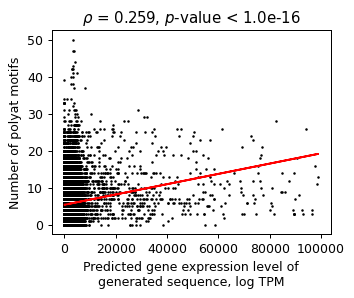

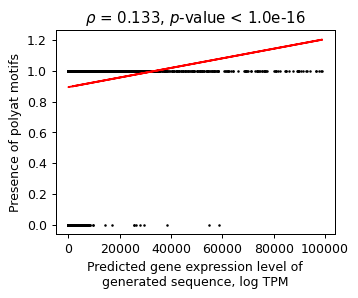

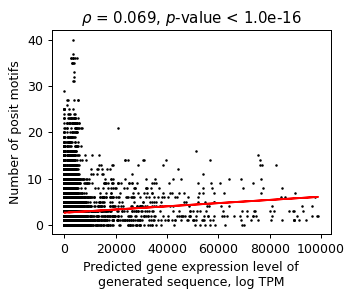

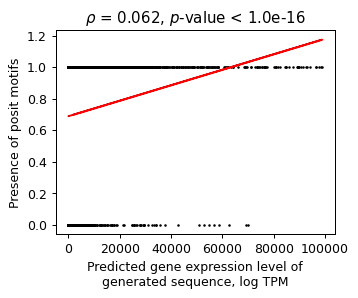

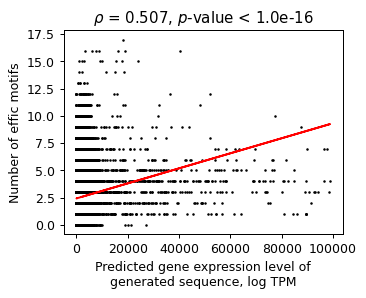

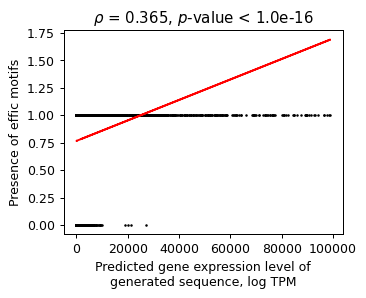

In [16]:
mpl.rcParams['figure.dpi'] = 90
for i in ['polyat_3utr',
          'posit_3utr',
          'effic_3utr',
         ]:

    plt.figure(figsize=(4,3))
    x = df_sel.y_tpm.values
    y = df_sel[i+'_num'].values
    slope1, intercept1, rvalue, pvalue, stderr = stats.linregress(x,y)
    plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
    plt.plot(x, intercept1+slope1*x, 'r', label='fitted line')
    plt.ylabel("Number of "+i.split('_')[0]+' motifs')
    plt.xlabel('Predicted gene expression level of\ngenerated sequence, log TPM')
    plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value < '+str("%.1e" % fix_pvals(pvalue)))
    r,p = stats.spearmanr(x,y)
    plt.title(r'$\rho$ = '+str("%.3f" % r)+ ', $p$-value < '+str("%.1e" % fix_pvals(p)))
    plt.show()
    
    plt.figure(figsize=(4,3))
    x = df_sel.y_tpm.values
    y = df_sel[i+'_pass'].astype(int).values
    slope1, intercept1, rvalue, pvalue, stderr = stats.linregress(x,y)
    plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
    plt.plot(x, intercept1+slope1*x, 'r', label='fitted line')
    plt.ylabel("Presence of "+i.split('_')[0]+' motifs')
    plt.xlabel('Predicted gene expression level of\ngenerated sequence, log TPM')
    plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value < '+str("%.1e" % fix_pvals(pvalue)))
    r,p = stats.spearmanr(x,y)
    plt.title(r'$\rho$ = '+str("%.3f" % r)+ ', $p$-value < '+str("%.1e" % fix_pvals(p)))
    plt.show()
    

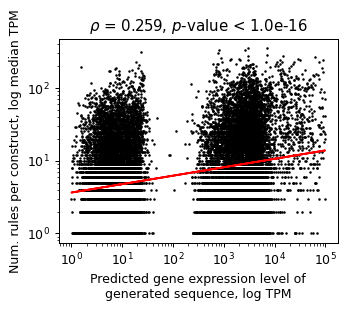

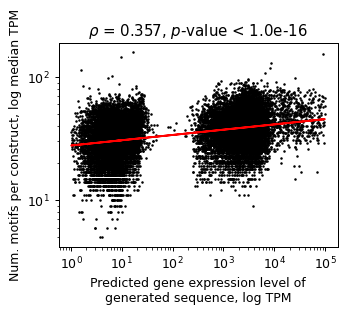

In [17]:
# Correlations predicted ytpms vs motifs and rules per sequence
mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(4,3))
x = df_sel6.groupby('seq').y_tpm.median().values
y = df_sel6.groupby('seq').ruleset.apply(len).values

slope1, intercept1, rvalue, pvalue, stderr = stats.linregress(np.log(x),np.log(y))
plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
plt.plot(x, powerfit(x,y,x), 'r', label='fitted line')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Num. rules per construct, log median TPM')
plt.xlabel('Predicted gene expression level of\ngenerated sequence, log TPM')
plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value < '+str("%.1e" % fix_pvals(pvalue)))
r,p = stats.spearmanr(x,y)
plt.title(r'$\rho$ = '+str("%.3f" % r)+ ', $p$-value < '+str("%.1e" % fix_pvals(p)))
plt.show()

plt.figure(figsize=(4,3))
x = df_sel6m.groupby('seq').y_tpm.median().values
y = df_sel6m.groupby('seq').clusterset.apply(len).values

slope1, intercept1, rvalue, pvalue, stderr = stats.linregress(np.log(x),np.log(y))
plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
plt.plot(x, powerfit(x,y,x), 'r', label='fitted line')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Num. motifs per construct, log median TPM')
plt.xlabel('Predicted gene expression level of\ngenerated sequence, log TPM')
plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value < '+str("%.1e" % fix_pvals(pvalue)))
r,p = stats.spearmanr(x,y)
plt.title(r'$\rho$ = '+str("%.3f" % r)+ ', $p$-value < '+str("%.1e" % fix_pvals(p)))
plt.show()


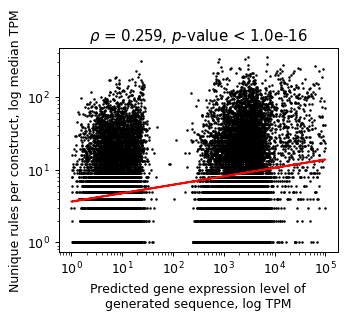

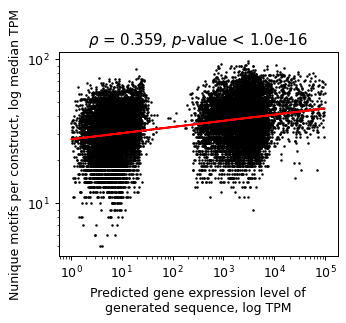

In [18]:
# correlation predicted ytpms vs nuniuqe motifs and rules per sequence

plt.figure(figsize=(4,3))
x = df_sel6.groupby('seq').y_tpm.median().values
y = df_sel6.groupby('seq').ruleset.nunique().values

slope1, intercept1, rvalue, pvalue, stderr = stats.linregress(np.log(x),np.log(y))
plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
plt.plot(x, powerfit(x,y,x), 'r', label='fitted line')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Nunique rules per construct, log median TPM')
plt.xlabel('Predicted gene expression level of\ngenerated sequence, log TPM')
plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value < '+str("%.1e" % fix_pvals(pvalue)))
r,p = stats.spearmanr(x,y)
plt.title(r'$\rho$ = '+str("%.3f" % r)+ ', $p$-value < '+str("%.1e" % fix_pvals(p)))
plt.show()

plt.figure(figsize=(4,3))
x = df_sel6m.groupby('seq').y_tpm.median().values
y = df_sel6m.groupby('seq').clusterset.nunique().values

slope1, intercept1, rvalue, pvalue, stderr = stats.linregress(np.log(x),np.log(y))
plt.scatter(x,y,s=1,alpha=1,c='k',label='original data')
plt.plot(x, powerfit(x,y,x), 'r', label='fitted line')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Nunique motifs per construct, log median TPM')
plt.xlabel('Predicted gene expression level of\ngenerated sequence, log TPM')
plt.title('$r$ = '+str("%.3f" % rvalue)+ ', $p$-value < '+str("%.1e" % fix_pvals(pvalue)))
r,p = stats.spearmanr(x,y)
plt.title(r'$\rho$ = '+str("%.3f" % r)+ ', $p$-value < '+str("%.1e" % fix_pvals(p)))
plt.show()


## Core promoter analysis

In [19]:
# TATA

# overall presence of TATA 
print(df_sel_core[['has_TATA','has_TATA-2']].sum().divide(df_sel_core.seq.count(),axis=0))

df_tata = (pd.read_csv(folder+'motifs_core_generated_hl_1e2_10000_tata_count.tsv',sep='\t')
           .set_index(['region','grouping'])
          )
print(df_tata)

val_tata = df_sel_core[['grouping', 'TATA_-200-100', 'TATA_-100-TSS',
       'TATA_-200-100_tf', 'TATA_-100-TSS_tf']]

# high one region vs other
print(df_tata.iloc[2]/df_tata.iloc[0])

# but its for diff in num of motifs
print(stats.ranksums(val_tata.query('grouping=="high"')['TATA_-200-100'],
                     val_tata.query('grouping=="high"')['TATA_-100-TSS']
     ))
# presence absence
print(stats.ranksums(val_tata.query('grouping=="high"')['TATA_-200-100'].apply(lambda x: x>0),
                     val_tata.query('grouping=="high"')['TATA_-100-TSS'].apply(lambda x: x>0)
     ))

# -200..-100 low vs high
print(df_tata.iloc[1]/df_tata.iloc[0])
print(stats.ranksums(val_tata.query('grouping=="low"')['TATA_-200-100'],
                     val_tata.query('grouping=="high"')['TATA_-200-100']
     ))
# presence absence
print(stats.ranksums(val_tata.query('grouping=="low"')['TATA_-200-100'].apply(lambda x: x>0),
                     val_tata.query('grouping=="high"')['TATA_-200-100'].apply(lambda x: x>0)
     ))


has_TATA      0.1807
has_TATA-2    0.9991
dtype: float64
                      TATA-2_count  TATA-1_count  TATA_count
region      grouping                                        
[-200,-100] high            0.7742        0.2448      0.0229
            low             0.9847        0.6327      0.1148
[-100,0]    high            0.9935        0.6012      0.0854
            low             0.9970        0.7286      0.1569
TATA-2_count    1.283260
TATA-1_count    2.455882
TATA_count      3.729258
dtype: float64
RanksumsResult(statistic=-7.689827711069098, pvalue=1.473332911083555e-14)
RanksumsResult(statistic=-7.6544640869872165, pvalue=1.941200519610563e-14)
TATA-2_count    1.271894
TATA-1_count    2.584559
TATA_count      5.013100
dtype: float64
RanksumsResult(statistic=11.325295221398488, pvalue=9.834697299492892e-30)
RanksumsResult(statistic=11.255123993506004, pvalue=2.1851856681573543e-29)


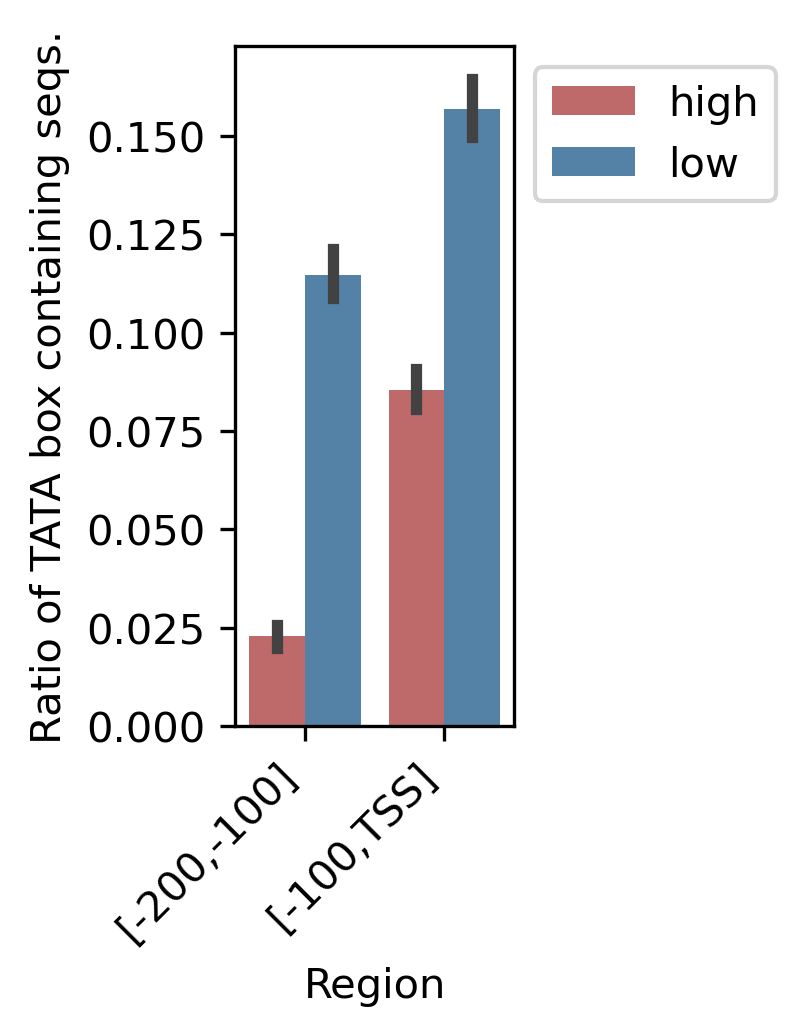

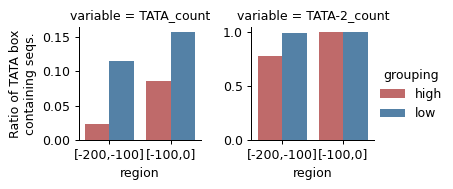

In [20]:
# TATA across regions
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(1.2,3))
sns.barplot(data=val_tata
            .melt(id_vars='grouping',
                  value_vars=['TATA_-200-100_tf','TATA_-100-TSS_tf']),
            x='variable',y='value',
            hue='grouping',
            palette=['indianred','steelblue'],
           )
plt.xticks([0,1],['[-200,-100]','[-100,TSS]'],
           rotation=45,ha='right')
plt.ylabel('Ratio of TATA box containing seqs.')
plt.xlabel('Region')
plt.legend(bbox_to_anchor=(1,1))
plt.show()

# supplementary
mpl.rcParams['figure.dpi'] = 90
g = sns.catplot(data=(df_tata
 .reset_index()
 .drop(columns=['TATA-1_count'])
 .melt(id_vars=['region','grouping'],value_vars=['TATA_count','TATA-2_count'])
),x='region',y='value',hue='grouping',col='variable',kind='bar',
           sharey=False,palette=['indianred','steelblue'],height=2)
g.axes[0,0].set_ylabel('Ratio of TATA box\ncontaining seqs.')
plt.show()


In [21]:
# T-richness and motifs

df_trich = pd.DataFrame(df_sel_core.groupby(['grouping'])
                        .t_richness.median()
                        .rename('avg_t_richness')
                       )

# avg. value per sequnce
df_trich['trich_count'] = (df_sel_core.groupby(['grouping'])
                     ['t_rich_num']
 .median()
)
df_trich['tpoor_count'] = (df_sel_core.groupby(['grouping'])
                     ['t_poor_num']
 .median()
)

# stats
print(stats.ranksums(df_sel_core.query('grouping=="high"')['t_rich_num'],
                     df_sel_core.query('grouping=="low"')['t_rich_num']
     ))
print(stats.ranksums(df_sel_core.query('grouping=="low"')['t_poor_num'],
                     df_sel_core.query('grouping=="high"')['t_poor_num']
     ))
print(stats.ranksums(df_sel_core.query('grouping=="high"')['t_richness'],
                     df_sel_core.query('grouping=="low"')['t_richness']
     ))

# values for text
df_trich.loc['high'].avg_t_richness/df_trich.loc['low'].avg_t_richness

df_trich


RanksumsResult(statistic=67.01217912578484, pvalue=0.0)
RanksumsResult(statistic=80.93100273413522, pvalue=0.0)
RanksumsResult(statistic=80.9849464981633, pvalue=0.0)


,avg_t_richness,trich_count,tpoor_count
grouping,,,
high,0.426667,9,3
low,0.306667,4,6


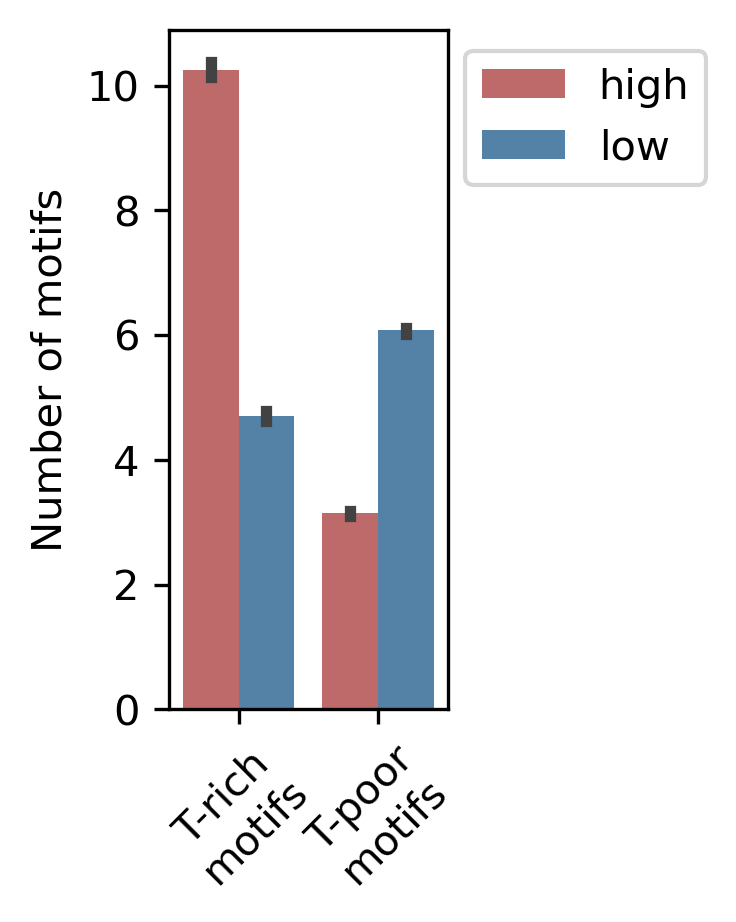

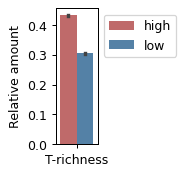

In [22]:
# plot motif counts
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(1.2,3))
sns.barplot(data=df_sel_core.melt(id_vars=['grouping'],
                               value_vars=['t_rich_num','t_poor_num']),
            x='variable',y='value',hue='grouping',
            palette=['indianred','steelblue'],
           )
plt.xticks([0,1],['T-rich\nmotifs','T-poor\nmotifs'],rotation=45,ha='center')
plt.legend(title='',bbox_to_anchor=(2,1))
plt.ylabel('Number of motifs')
plt.xlabel('')
plt.show()

# supplementary
df_sel_core['type'] = 'val'
mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(0.6,2))
sns.barplot(data=df_sel_core,
            x='type',y='t_richness',hue='grouping',
            palette=['indianred','steelblue'],
           )
plt.legend(title='',bbox_to_anchor=(1,1))
plt.ylabel('Relative amount')
plt.xlabel('')
plt.xticks([0],['T-richness'])
plt.show()

In [23]:
# INR motifs

df_inr = (df_sel_core.groupby(['grouping'])
                     ['inr_num']
 .apply(list)
 .apply(lambda x: sum([1 for xx in x if xx>0])) # contains at least a single one
 .divide(df_sel_core.groupby(['grouping']).seq.count())
)
print(df_inr.iloc[0]/df_inr.iloc[1])
print(df_inr)

# overall inr
print(df_sel_core.groupby('type').inr_num
 .apply(list)
 .apply(lambda x: sum([1 for xx in x if xx>0]))
 .divide(df_sel_core.seq.count())
)

# check vs has tata
tmp = (df_sel_core.groupby(['has_TATA'])
                     ['inr_num']
 .apply(list)
 .apply(lambda x: sum([1 for xx in x if xx>0]))
 .divide(df_sel_core.groupby(['has_TATA']).seq.count())
)
print(tmp)
print(tmp.iloc[0]/tmp.iloc[1]-1)

# stats for diff in numbers of INR
print(stats.ranksums(df_sel_core.query('grouping=="high"')['inr_num'],
                     df_sel_core.query('grouping=="low"')['inr_num']
     ))
print(stats.ranksums(df_sel_core.query('has_TATA==False')['inr_num'],
                     df_sel_core.query('has_TATA==True')['inr_num']
     ))

# #  diff in just num inr carrying (at least one)
# df_sel_core['inr_tf'] = df_sel_core.inr_num.apply(lambda x: 1 if x>0 else 0)

print(stats.ranksums(df_sel_core.query('grouping=="high"')['inr_tf'],
                     df_sel_core.query('grouping=="low"')['inr_tf']
     ))
print(stats.ranksums(df_sel_core.query('has_TATA==False')['inr_tf'],
                     df_sel_core.query('has_TATA==True')['inr_tf']
     ))


2.2888684452621892
grouping
high    0.4976
low     0.2174
dtype: float64
type
val    0.3575
Name: inr_num, dtype: float64
has_TATA
False    0.378372
True     0.262867
dtype: float64
0.4394059113363784
RanksumsResult(statistic=36.540825546318146, pvalue=2.4940610314978887e-292)
RanksumsResult(statistic=11.419628440019068, pvalue=3.3365735529009725e-30)
RanksumsResult(statistic=34.31649339478109, pvalue=4.454120903073471e-258)
RanksumsResult(statistic=10.885958493142558, pvalue=1.344764295940246e-27)


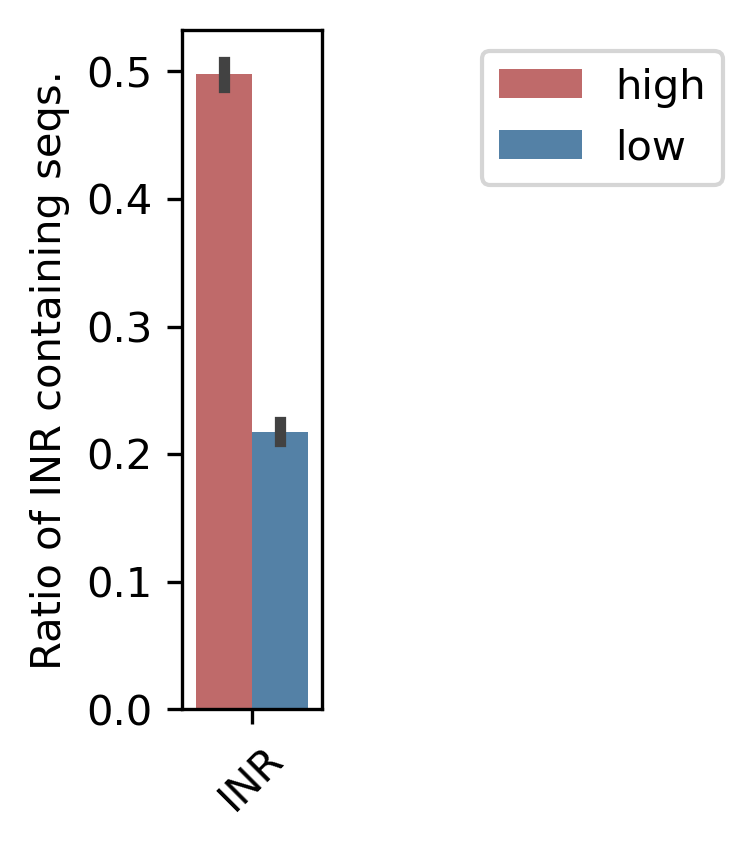

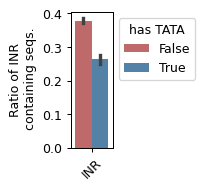

In [24]:
# plot 
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(0.6,3))
sns.barplot(data=df_sel_core,
            x='type',y='inr_tf',
            hue='grouping',
            palette=['indianred','steelblue'],
           )
plt.xticks([0],['INR'],rotation=45,ha='center')
plt.legend(bbox_to_anchor=(2,1))
plt.xlabel('')
plt.ylabel('Ratio of INR containing seqs.')
plt.show()

mpl.rcParams['figure.dpi'] = 90
plt.figure(figsize=(0.6,2))
sns.barplot(data=df_sel_core,
            x='type',y='inr_tf',
            hue='has_TATA',
            palette=['indianred','steelblue'],
           )
plt.xticks([0],['INR'],rotation=45,ha='center')
plt.legend(title='has TATA',bbox_to_anchor=(1,1))
plt.xlabel('')
plt.ylabel('Ratio of INR\n containing seqs.')
plt.show()



[1.6]
RanksumsResult(statistic=11.55391263117735, pvalue=7.053459315808113e-31)


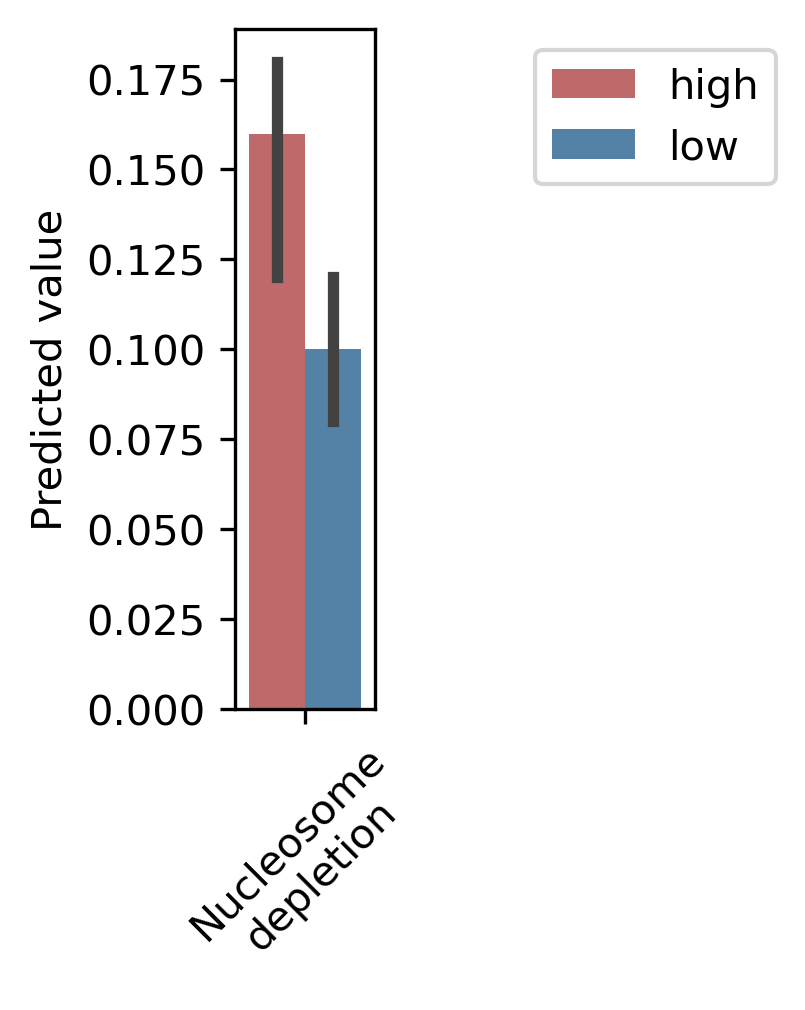

In [25]:
# nucleosome depletion

tmp = df_sel_core.groupby('grouping')[['nucpos_depleted',
                                     ]].median()
print((tmp.loc['high']/tmp.loc['low']).values)

print(stats.ranksums(df_sel_core.query('grouping=="high"')['nucpos_depleted'],
                     df_sel_core.query('grouping=="low"')['nucpos_depleted']
     ))

# plot
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(0.6,3))
sns.barplot(data=df_sel_core,
            x='type',y='nucpos_depleted',
            hue='grouping',
           palette=['indianred','steelblue'],
            estimator=np.median, ci=95
           )
plt.xticks([0],['Nucleosome\ndepletion'],rotation=45,ha='center')
plt.legend(bbox_to_anchor=(2,1))
plt.xlabel('')
plt.ylabel('Predicted value')
plt.show()